In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt

#For Random Forest
from collections import Counter

#For PCA
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import svd

#For Supervised Learning
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

#For Voting Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

#For Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
#Read data from data set
data = np.genfromtxt("data.csv", delimiter=",", skip_header=1)

X_old = data[:, :-1]
Y_old = data[:, -1]

##Normalise the data
#scaler = MinMaxScaler()
#X_new = scaler.fit_transform(X_old)

#Splitting the data into train(80%), test(20%)  
X_train, X_test, Y_train, Y_test = train_test_split(X_old, Y_old, test_size=0.2)

In [3]:
def Normalize(Xtrain, Xtest):
    X = np.concatenate((Xtrain, Xtest), 0)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_left = X[:len(Xtrain),]
    X_right = X[len(Xtrain):,]
    return X_left, X_right

In [4]:
def NormalizeTrain(Xtrain):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(Xtrain)
    return X

In [5]:
def Accuracy(y_t, y_p):
    y_true = y_t
    y_pred = y_p
    total_count = len(y_true)
    result = np.equal(y_true, y_pred)
    count = np.count_nonzero(result)
    accuracy = count / total_count
    return accuracy

In [6]:
def Recall(y_t,y_p):
    y_true = y_t
    y_pred = y_p
    y_set = set(y_true) 
    numerator = 0
    unique_labels = (list(y_set)) 
    for y in unique_labels: 
        tp = sum((y_true == float(y)) & (y_pred == float(y)))
        tn = sum((y_true != float(y)) & (y_pred != float(y)))
        fn = sum((y_true == float(y)) & (y_pred != float(y)))
        fp = sum((y_true != float(y)) & (y_pred == float(y)))
        numerator += tp/float(tp + fn)
    return float(numerator/len(unique_labels)) 

In [7]:
def Precision(y_t,y_p):
    y_true = y_t
    y_pred = y_p
    y_set = set(y_true) 
    numerator = 0
    unique_labels = (list(y_set)) 
    for y in unique_labels: 
        tp = sum((y_true == float(y)) & (y_pred == float(y)))
        tn = sum((y_true != float(y)) & (y_pred != float(y)))
        fn = sum((y_true == float(y)) & (y_pred != float(y)))
        fp = sum((y_true != float(y)) & (y_pred == float(y)))
        numerator += tp/float(tp + fp)
    return float(numerator/len(unique_labels))

In [8]:
def WCSS(clusterLst):
    """
    :Clusters List[numpy.ndarray]
    :rtype: float
    """
    clusterList = clusterLst
    features = len(clusterList[0][0])
    clusters = len(clusterList)
    centroidArray = np.zeros((features, clusters))
    
    wcss=0
    for k in range(clusters):
        centroidArray[:,k] = np.mean(clusterList[k],axis=0)
        wcss += np.sum((clusterList[k] - centroidArray[:,k])**2)
        
    return wcss

In [9]:
def ConfusionMatrix(y_t,y_p):
    
    """
    :type y_true: numpy.ndarray
    :type y_pred: numpy.ndarray
    :rtype: float
    """
    y_true = y_t
    y_pred = y_p
    n = len(np.unique(y_true)) #Number of classes 
    cm = np.zeros((n, n))
    
    startIndex = int(np.amin(y_true)) #When classes don't start from zero, we need to take care of offset
    
    for i in range(len(y_true)):
        cm[int(y_true[i])-startIndex][int(y_pred[i])-startIndex] += 1

    return cm

In [10]:
def KNN(X_tr, X_tst, Y_tr, N):
    """
    :type X_train: numpy.ndarray
    :type X_test: numpy.ndarray
    :type Y_train: numpy.ndarray
    
    :rtype: numpy.ndarray
    """
    Xtrain, Xtest = Normalize(X_tr, X_tst)
    #Xtrain = X_tr
    #Xtest = X_tst
    Ytrain = Y_tr
    K = N
    
    distances = -2 * np.dot(Xtest, Xtrain.T) + np.sum(Xtrain**2, axis=1) + np.sum(Xtest**2, axis=1)[:, np.newaxis]
    KIndices = np.argsort(distances)[:, :K]
    KLabels = np.take(Ytrain, KIndices)
    test_pred = np.amax(KLabels, axis=1)
    return test_pred

In [11]:
def RandomForest(X_tr, Y_tr, X_tst):
    """
    :type X_train: numpy.ndarray
    :type X_test: numpy.ndarray
    :type Y_train: numpy.ndarray
    
    :rtype: numpy.ndarray
    """
    Xtrain, Xtest = Normalize(X_tr, X_tst)
    #Xtrain = X_tr
    #Xtest = X_tst
    Ytrain = Y_tr
    
    class Node:
        def __init__(self, decision, feature,left_node, right_node):
            self.decision = decision
            self.left_node = left_node
            self.right_node = right_node
            self.feature = feature
    
    class Leaf_Node:        
        def __init__(self, Xtrain):
            self.predictions = get_max_label(Xtrain)
            self.Xtrain = Xtrain
            
    def get_max_label(Xtrain):
        uniqueValues = calculate_label_counts(Xtrain)
        maxLabel = max(uniqueValues, key=uniqueValues.get)
        return maxLabel
    
    def calculate_label_counts(Xtrain):
        uniqueValues, occurCount = np.unique(Xtrain[:,-1], return_counts=True)
        listOfUniqueValues = dict(zip(uniqueValues, occurCount))
        return listOfUniqueValues
            
    def get_dec (col):
        cols_sorted = np.sort(col)
        min_val = cols_sorted[0]
        max_val = cols_sorted[len(cols_sorted)-1]
        val_a = min_val + (max_val - min_val)*1/3
        val_b = min_val + (max_val - min_val)*2/3
        return [val_a, val_b]
    
    def best_gain_split(rows, features):
        max_gain = 0
        max_f = 0
        best_decision = None
        parent_impurity = get_gini(rows)
        left_max = []
        right_max = []
        for f in features:
            dec = get_dec(rows[:, f])
            for d in dec:
                left, right = get_partition(rows,d,f)
                if left.shape[0] == 0 or right.shape[0] == 0:
                    continue
                gain = get_gain(left, right, parent_impurity, rows)
                if(gain > max_gain):
                    max_gain = gain
                    best_decision = d
                    max_f = f
                    left_max = left
                    right_max = right
        return max_gain, best_decision,max_f
    
    def get_partition(rows, decision, feature):
        right =[]
        left =[]
        for r in rows:
            if(r[feature] > decision):
                right.append(r)
            else:
                left.append(r)
        right = np.asarray(right)
        left = np.asarray(left)
        return left, right
    
    def get_gain(left,right,parent_impurity,rows):
        return parent_impurity - ((float(left.shape[0]/rows.shape[0]))* float(get_gini(left)))-((float(right.shape[0])/rows.shape[0])*float(get_gini(right)))
    
    def get_gini(rows):
        labels = calculate_label_counts(rows)
        I = 1
        for label,freq in labels.items():
                I  = I - ((float(freq)/rows.shape[0])**2)
        return I
            
    
    def decision_tree(Xtrain, tree_depth, max_depth, features):
        gain, condition, f = best_gain_split(Xtrain, features)
        
        if gain == 0 or tree_depth == max_depth:
            return Leaf_Node(Xtrain)
        
        left_rows, right_rows = get_partition(Xtrain, condition, f)
        
        left_node = create_tree(left_rows, tree_depth + 1, max_depth)
        right_node = create_tree(right_rows, tree_depth + 1, max_depth)
        
        return Node(condition, f,left_node, right_node)
    
    def create_tree(Xtrain, tree_depth, max_depth):
        n_features = int(np.sqrt(Xtrain.shape[1]))
        random_features = np.random.permutation(Xtrain.shape[1]-1)[:n_features]
        return decision_tree(Xtrain, tree_depth, max_depth, random_features)
    
    def predict(x, node):
        if isinstance(node,Leaf_Node):
            return node.predictions
        elif x[node.feature]>node.decision:
            return predict(x,node.right_node)
        else:
            return predict(x,node.left_node)  
    
    def test(trees, Xtest):
        Y_pred = np.zeros(shape = (len(Xtest)))
        i = 0
        for row in Xtest:
            labels = []
            for tree in trees:
                label_predicted = predict(row, tree)
                labels.append(label_predicted)
            labels = Counter(labels) 
            res = labels.most_common(1)[0][0] 
            Y_pred[i] = res
            i = i + 1
        return Y_pred
    
    Ytrain = np.asmatrix(Ytrain)
    Xtrain = np.append(Xtrain, Ytrain.T, axis=1)
    Xtrain = np.asarray(Xtrain)
    
    n_trees = 3
    trees = [create_tree(Xtrain, 1, 12) for i in range(n_trees)]
    
    result = test(trees, Xtest)
    return result

In [12]:
def PCA(X_tr,N):
    """
    :type X_train: numpy.ndarray
    :type N: int
    :rtype: numpy.ndarray
    """
    X_ = NormalizeTrain(X_tr)
    #X = X_tr
    M = mean(X_.T, axis=1)
    C = X_-M
    E1,E2,E3 = svd(C,full_matrices=False)
    vectors = np.diag(E2)
    result = E1[:, 0:N].dot(vectors[0:N, 0:N])
    return result

In [13]:
def Kmeans(X_tr, N):
    """
    :type X_train: numpy.ndarray
    :type N: int
    :rtype: List[numpy.ndarray]
    """
    Xtrain = NormalizeTrain(X_tr)
    #Xtrain = X_tr
    
    rows = Xtrain.shape[0] #dataset
    features = Xtrain.shape[1] #features
    iterations = 100
    threshold = 0.0001
    
    centroidArray = np.array([]).reshape(features, 0)
    for i in range(N):
        centroidArray = np.c_[centroidArray, Xtrain[i]]

    for i in range(iterations):
        distance = np.array([]).reshape(rows,0)
        for k in range(N):
            temp = np.sum((Xtrain - centroidArray[:,k])**2,axis=1)
            distance = np.c_[distance, temp]

        row_cluster = np.argmin(distance, axis=1) #array storing the cluster number for each row
        previous = centroidArray.T

        clusters = [np.array([])]*N #list for clusters which will store which all rows belong to a given cluster
        for k in range(N):
            clusters[k] = np.array([]).reshape(features, 0) 

        for i in range(rows):
            clusters[row_cluster[i]] = np.c_[clusters[row_cluster[i]], Xtrain[i]]

        for k in range(N):
            clusters[k] = clusters[k].T
            centroidArray[:,k] = np.mean(clusters[k], axis=0)
            
        original = centroidArray.T
        limitReached = True        

        for k in range(N):
            if np.sum((original[k] - previous[k])/previous[k] * 100.0) > threshold:
                limitReached = False

        if limitReached:
            break   
    return clusters

In [14]:
def SklearnSupervisedLearning(X_tr, Y_tr, X_tst, Y_tst):
    """
    :type X_train: numpy.ndarray
    :type X_test: numpy.ndarray
    :type Y_train: numpy.ndarray
    
    :rtype: List[numpy.ndarray] 
    """
    Xtrain, Xtest = Normalize(X_tr, X_tst)
    #Xtrain = X_tr
    #Xtest = X_tst
    Ytrain = Y_tr
    Ytest = Y_tst
    
    result = []
    
    #Logistic Regression
    lr = LogisticRegression(max_iter=10000, solver = 'lbfgs', random_state=0)
    lr.fit (Xtrain, Ytrain)
    lr_predict = lr.predict(Xtest)
    lr_acc = Accuracy(lr_predict, Ytest)
    print ("LR Accuracy:", lr_acc)
    result.append(lr_predict)
    
    #Decision Tree
    dt = tree.DecisionTreeClassifier()
    dt.fit (Xtrain, Ytrain)
    dt_predict = dt.predict(Xtest)
    dt_acc = Accuracy(dt_predict, Ytest)
    print ("DT Accuracy:", dt_acc)
    result.append(dt_predict)
    
    #SVM
    sv = svm.SVC(kernel = 'linear')
    sv.fit(Xtrain,Ytrain)
    sv_predict = sv.predict(Xtest)
    sv_acc = Accuracy(sv_predict, Ytest)
    print ("SVM Accuracy:", sv_acc)
    result.append(sv_predict)
    
    #KNN
    knn = KNeighborsClassifier(n_neighbors = 4)
    knn.fit(Xtrain, Ytrain)
    knn_predict = knn.predict(Xtest)
    knn_acc = Accuracy(knn_predict, Ytest)
    print ("KNN Accuracy:", knn_acc)
    result.append(knn_predict)
    
    return result

In [15]:
def SklearnVotingClassifier(X_tr, Y_tr, X_tst, Y_tst):   
    """
    :type X_train: numpy.ndarray
    :type X_test: numpy.ndarray
    :type Y_train: numpy.ndarray
    
    :rtype: List[numpy.ndarray] 
    """
    Xtrain, Xtest = Normalize(X_tr, X_tst)
    #Xtrain = X_tr
    #Xtest = X_tst
    Ytrain = Y_tr
    Ytest = Y_tst    
    
    log_clf = LogisticRegression()
    knn_clf = KNeighborsClassifier()
    svm_clf = SVC()
    dtree_clf = DecisionTreeClassifier()

    voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('knn', knn_clf), ('svc',svm_clf), ('dt',dtree_clf)],
        voting = 'hard')
    voting_clf.fit(Xtrain, Ytrain)
    y_pred = voting_clf.predict(Xtest)
    print("Voting Classifier's accuracy:", Accuracy(Ytest, y_pred))
    return y_pred

In [16]:
def plotConfusionMatrix(cm, Ytest, classifier):
    plotTitle = "Confusion Matrix: " + classifier
    s = set(Ytest)
    lst = list(s)
    #lst = [int(i) for i in lst]

    fig, a = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    im = a.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm)
    
    a.set_xticks(np.arange(len(lst)))
    a.set_yticks(np.arange(len(lst)))
    a.set_xticklabels(lst)
    a.set_yticklabels(lst)
    a.set_title(plotTitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(lst)):
        for j in range(len(lst)):
            text = a.text(j, i, int(cm[i, j]), ha="center", va="center", color='w')
    fig.tight_layout()
    plt.show()

# Implementation

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

knn_scratch_acc: 0.9453125
knn_sklearn_acc: 0.987060546875
knn_scratch_pre: 0.9498005122909473
knn_sklearn_pre: 0.9870797523641329
knn_scratch_rec: 0.9450964271573011
knn_sklearn_rec: 0.9870685158124842
knn_scratch_cm:
 [[626.   0.   0.   0.   1. 100.   0.   2.   5.   0.   0.]
 [  0. 593.   0.   0.   1.   0.   0.   0.   3. 136.   0.]
 [  0.   0. 746.   7.  20.   3.   0.   2.   3.   0.   0.]
 [  0.   0.   0. 692.  23.   0.   0.   5.   1.   0.   0.]
 [  0.   0.   0.   1. 715.   1.   0.  40.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 664.   0.   9.  74.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 756.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 755.   3.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   2. 775.   4.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 697.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 725.]]


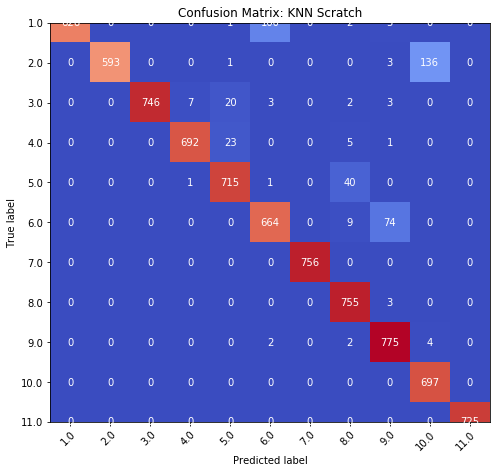

In [18]:
## KNN ##

#scratch
knn_scratch_predict = KNN(X_train, X_test, Y_train, 7)
knn_scratch_acc = Accuracy(Y_test, knn_scratch_predict)
knn_scratch_pre = Precision(Y_test, knn_scratch_predict)
knn_scratch_rec = Recall(Y_test, knn_scratch_predict)
knn_scratch_cm = ConfusionMatrix(Y_test, knn_scratch_predict)

#sklearn
Xtrain, Xtest = Normalize(X_train, X_test)
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(Xtrain, Y_train)
knn_sklearn_predict = knn.predict(Xtest)
knn_sklearn_acc = Accuracy(Y_test, knn_sklearn_predict)
knn_sklearn_pre = Precision(Y_test, knn_sklearn_predict)
knn_sklearn_rec = Recall(Y_test, knn_sklearn_predict)
knn_sklearn_cm = ConfusionMatrix(Y_test, knn_sklearn_predict)

#printing
print ("knn_scratch_acc:", knn_scratch_acc)
print ("knn_sklearn_acc:", knn_sklearn_acc)
print ("knn_scratch_pre:", knn_scratch_pre)
print ("knn_sklearn_pre:", knn_sklearn_pre)
print ("knn_scratch_rec:", knn_scratch_rec)
print ("knn_sklearn_rec:", knn_sklearn_rec)
print ("knn_scratch_cm:\n", knn_scratch_cm)
plotConfusionMatrix(knn_scratch_cm, Y_test, "KNN Scratch")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rf_scratch_acc: 0.96142578125
rf_sklearn_acc: 0.9971923828125
rf_scratch_pre: 0.9621824190481868
rf_sklearn_pre: 0.997219851074934
rf_scratch_rec: 0.9618967372584085
rf_sklearn_rec: 0.9972418342367827
rf_scratch_cm:
 [[698.   0.   0.   0.   2.  26.   0.   0.   8.   0.   0.]
 [  0. 722.   1.   0.   1.   0.   0.   0.   0.   9.   0.]
 [  0.   0. 777.   1.   3.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1. 711.   8.   0.   0.   1.   0.   0.   0.]
 [  8.   0.  12.   4. 694.  11.   0.  28.   0.   0.   0.]
 [ 15.   0.   0.   0.   2. 680.   0.   0.  50.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 756.   0.   0.   0.   0.]
 [ 15.   0.   2.   8.  10.   4.   0. 719.   0.   0.   0.]
 [  5.   1.   4.   0.   0.  64.   0.   0. 709.   0.   0.]
 [  0.  12.   0.   0.   0.   0.   0.   0.   0. 685.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 725.]]


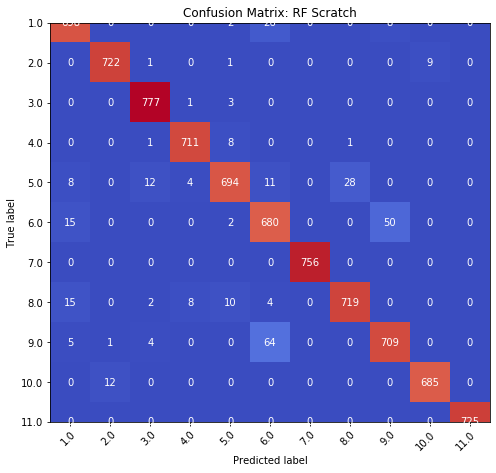

In [19]:
## RANDOM FOREST ##

#scratch
rf_scratch_predict = RandomForest(X_train, Y_train, X_test)
rf_scratch_acc = Accuracy(Y_test, rf_scratch_predict)
rf_scratch_pre = Precision(Y_test, rf_scratch_predict)
rf_scratch_rec = Recall(Y_test, rf_scratch_predict)
rf_scratch_cm = ConfusionMatrix(Y_test, rf_scratch_predict)

#sklearn
Xtrain, Xtest = Normalize(X_train, X_test)
from sklearn.ensemble import RandomForestClassifier
def RFSklearn(X_train, Y_train, X_test):
    clf_list = [('RF classifier', RandomForestClassifier())]
    for model_tuple in clf_list:
        model = model_tuple[1]
        if 'random_state' in model.get_params().keys():
            model.set_params(random_state=42)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
    return y_pred
 
rf_sklearn_predict = RFSklearn(Xtrain, Y_train, Xtest)
rf_sklearn_acc = Accuracy(Y_test, rf_sklearn_predict)
rf_sklearn_pre = Precision(Y_test, rf_sklearn_predict)
rf_sklearn_rec = Recall(Y_test, rf_sklearn_predict)
rf_sklearn_cm = ConfusionMatrix(Y_test, rf_sklearn_predict)

#printing
print ("rf_scratch_acc:", rf_scratch_acc)
print ("rf_sklearn_acc:", rf_sklearn_acc)
print ("rf_scratch_pre:", rf_scratch_pre)
print ("rf_sklearn_pre:", rf_sklearn_pre)
print ("rf_scratch_rec:", rf_scratch_rec)
print ("rf_sklearn_rec:", rf_sklearn_rec)
print ("rf_scratch_cm:\n", rf_scratch_cm)
plotConfusionMatrix(rf_scratch_cm, Y_test, "RF Scratch")

In [20]:
## PCA ##

#scratch
pca_scratch = PCA(X_train, 3)

#sklearn
Xtrain = NormalizeTrain(X_train)
from sklearn.decomposition import PCA
def PCASklearn(X_train):
    pca = PCA(n_components=3)
    x = np.array(X_train, dtype = np.float)
    principalComponents = pca.fit_transform(x)
    return principalComponents

pca_sklearn = PCASklearn(Xtrain)

#printing
print ("pca_scratch:\n", pca_scratch)
print ("pca_Sklearn:\n", pca_sklearn)

pca_scratch:
 [[ 0.35150271  0.23757072  0.17057367]
 [-0.98660091  0.00629267  0.20970123]
 [ 0.71531548  0.43808671 -0.12606291]
 ...
 [ 1.14785677  0.03603394  0.16827977]
 [-0.06539175  0.18933653  0.0319696 ]
 [ 0.27174182  0.04574793  0.24690794]]
pca_Sklearn:
 [[-0.35150271 -0.23757072 -0.17057366]
 [ 0.98660091 -0.00629267 -0.20970123]
 [-0.71531548 -0.43808671  0.12606292]
 ...
 [-1.14785677 -0.03603394 -0.16827977]
 [ 0.06539175 -0.18933653 -0.0319696 ]
 [-0.27174182 -0.04574793 -0.24690794]]


In [21]:
## K Means ##

#scratch
clusters = Kmeans(X_train, 3)
print ("Clusters:\n", clusters)

Clusters:
 [array([[0.59637156, 0.54463725, 0.64564478, ..., 0.35586207, 0.38493724,
        0.34770889],
       [0.59662828, 0.54498021, 0.64450464, ..., 0.28      , 0.30822873,
        0.27088949],
       [0.59676868, 0.54715897, 0.64449754, ..., 0.33793103, 0.36680614,
        0.33153639],
       ...,
       [0.59638766, 0.54300593, 0.65765121, ..., 0.30896552, 0.33751743,
        0.30053908],
       [0.59684207, 0.5442694 , 0.64660221, ..., 0.33103448, 0.35983264,
        0.32479784],
       [0.5963874 , 0.54934404, 0.61749715, ..., 0.30344828, 0.33333333,
        0.29649596]]), array([[0.59632185, 0.54437419, 0.64423531, ..., 0.33103448, 0.35983264,
        0.32210243],
       [0.59533399, 0.55000996, 0.6316436 , ..., 0.25517241, 0.28172943,
        0.25471698],
       [0.5954224 , 0.53671952, 0.68240377, ..., 0.26758621, 0.29567643,
        0.26415094],
       ...,
       [0.59669779, 0.55326941, 0.65454417, ..., 0.4       , 0.42817294,
        0.39083558],
       [0.59622516, 0.

In [22]:
## WCSS ##

#scratch
wcss = WCSS(clusters)
print("wcss:", wcss)

wcss: 11022.158314835442


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR Accuracy: 0.721435546875
DT Accuracy: 0.984375
SVM Accuracy: 0.8975830078125
KNN Accuracy: 0.9857177734375


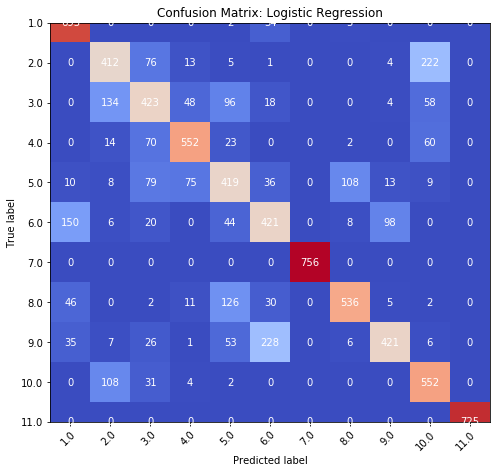

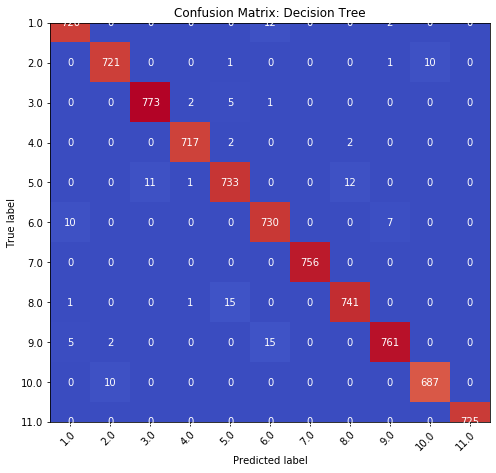

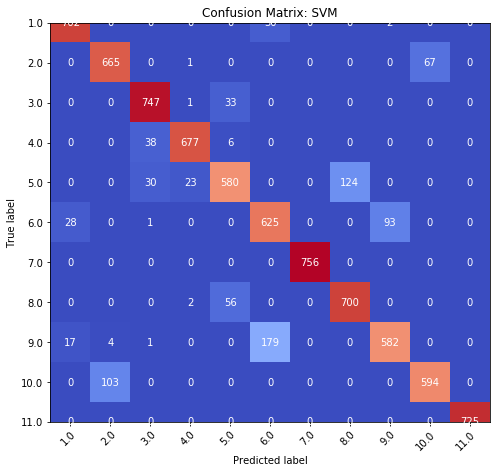

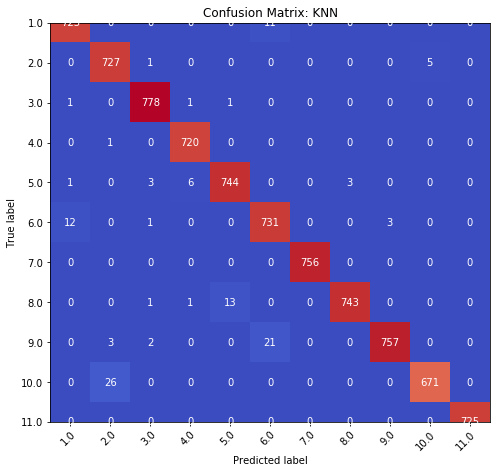

In [23]:
## SUPERVISED LEARNING ALGORITHMS ##

SL_predict = SklearnSupervisedLearning(X_train, Y_train, X_test, Y_test)
SL_classifiers = ['Logistic Regression', 'Decision Tree', 'SVM', 'KNN']
SL_cm = []
for i in range (len(SL_predict)):
    cm = ConfusionMatrix(Y_test, SL_predict[i])
    plotConfusionMatrix(cm, Y_test, SL_classifiers[i])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Voting Classifier's accuracy: 0.9224853515625


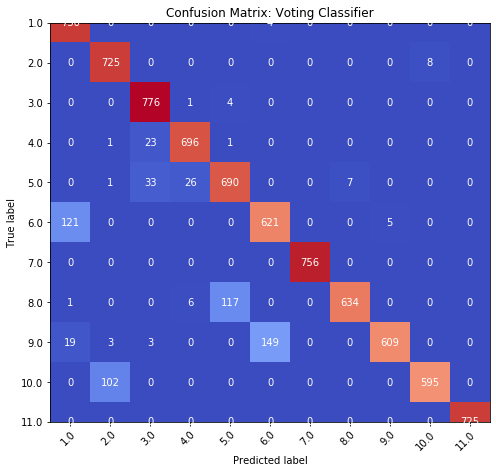

In [24]:
## SUPERVISED LEARNING VOTING CLASSIFIER ##

SLV_predict = SklearnVotingClassifier(X_train,Y_train,X_test, Y_test)
cm = ConfusionMatrix(Y_test, SLV_predict)
plotConfusionMatrix(cm, Y_test, "Voting Classifier")

# Grid Search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
No handles with labels found to put in legend.


Best Hyper Parameter: {'max_features': 'sqrt', 'min_samples_split': 6}
Accuracy for Best Hyperparamter: 0.9769287109375


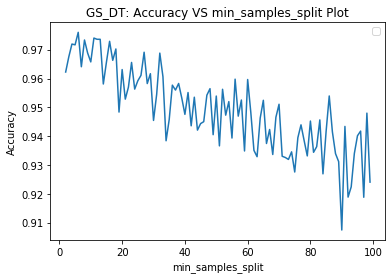

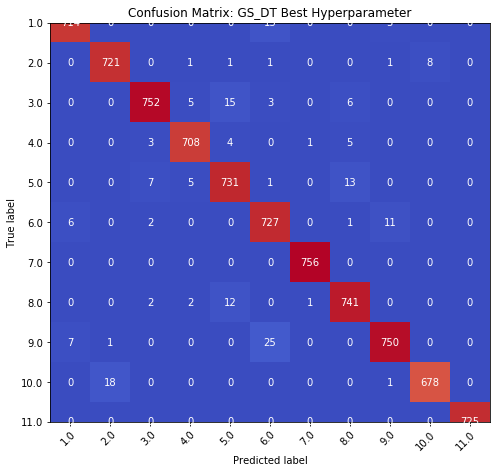

In [25]:
### DECISION TREE ###

Xtrain, Xtest = Normalize(X_train, X_test)
params = {'max_features': ['sqrt'],'min_samples_split' : range(2, 100)}

model1 = GridSearchCV(DecisionTreeClassifier(), param_grid = params, n_jobs=-1)
model1.fit(Xtrain, Y_train)

print("Best Hyper Parameter:",model1.best_params_)

Y_predict = model1.predict(Xtest)

print("Accuracy for Best Hyperparamter:",metrics.accuracy_score(Y_predict, Y_test))

plt.plot(range(2, 100), model1.cv_results_['mean_test_score'])
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title("GS_DT: Accuracy VS min_samples_split Plot")
plt.legend()

gridSearch_dt_cm = ConfusionMatrix(Y_test, Y_predict)
plotConfusionMatrix(gridSearch_dt_cm, Y_test, "GS_DT Best Hyperparameter")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameter:  {'n_neighbors': 5}


No handles with labels found to put in legend.


Accuracy for Best Hyperparamter: 0.98779296875


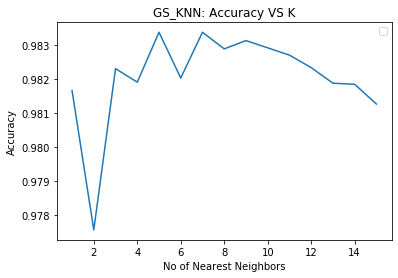

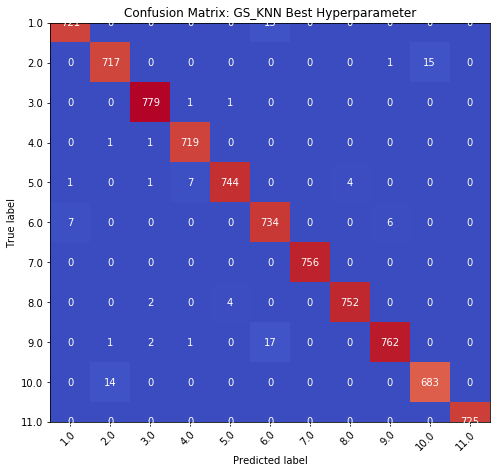

In [26]:
### KNN ###

Xtrain, Xtest = Normalize(X_train, X_test)
k_range = list(range(1, 16))

params = {'n_neighbors':k_range,}

model2 = GridSearchCV(KNeighborsClassifier(), param_grid=params, n_jobs = -1)
model2.fit(Xtrain, Y_train)

print("Best Hyper Parameter: ", model2.best_params_)

Y_predict = model2.predict(Xtest)

print("Accuracy for Best Hyperparamter:",metrics.accuracy_score(Y_predict, Y_test))

plt.plot(k_range, model2.cv_results_['mean_test_score'])
plt.xlabel('No of Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title("GS_KNN: Accuracy VS K")
plt.legend()

gridSearch_knn_cm = ConfusionMatrix(Y_test, Y_predict)
plotConfusionMatrix(gridSearch_knn_cm, Y_test, "GS_KNN Best Hyperparameter")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameters: {'C': 100, 'kernel': 'linear'}


No handles with labels found to put in legend.


Accuracy for Best Hyperparamter: 0.9189453125


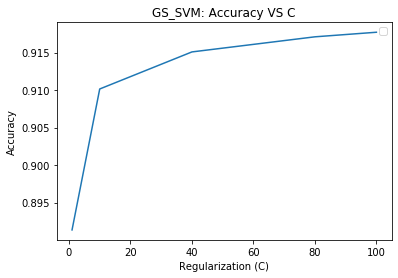

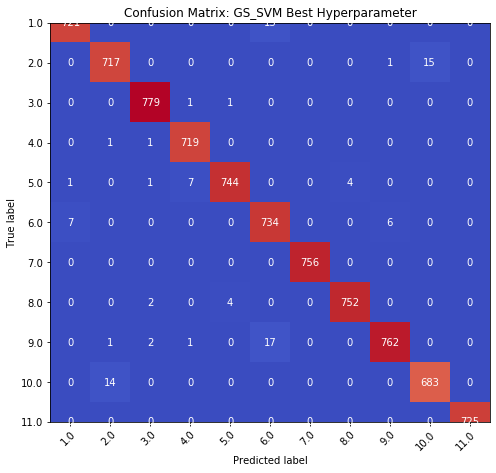

In [27]:
### SVM ###

Xtrain, Xtest = Normalize(X_train, X_test)
params = {'C': [1, 10, 40, 80, 100],'kernel': ['linear']}

model3 = GridSearchCV(SVC(), param_grid = params, n_jobs=-1) 
model3.fit(Xtrain, Y_train) 
 
print("Best Hyper Parameters:", model3.best_params_)

Y_predict = model3.predict(Xtest)

print("Accuracy for Best Hyperparamter:",metrics.accuracy_score(Y_predict, Y_test))

plt.plot([1, 10, 40, 80, 100], model3.cv_results_['mean_test_score'])
plt.xlabel('Regularization (C)')
plt.ylabel('Accuracy')
plt.title("GS_SVM: Accuracy VS C")
plt.legend()

gridSearch_SVM_cm = ConfusionMatrix(Y_test, Y_predict)
plotConfusionMatrix(gridSearch_knn_cm, Y_test, "GS_SVM Best Hyperparameter")